# Data Science Workshop

# Data Loading

## Import Python Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.linear_model as lm
from sklearn import metrics, preprocessing, svm
from sklearn.model_selection import cross_val_score

import random

%matplotlib inline

## Reading the Income Classification Dataset

In [2]:
# read the entire file into a python array
with open('raw_data.json', 'rb') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
raw_data = pd.read_json(data_json_str)

In [ ]:
# TODO: add photos anf feed data

# Data preparation

In [3]:
# currentLocation and current_location are too sparse and it's not clear if its a city/country etc..
ready_feats = ['has_cover_photo', 'has_profile_photo', 'id', 'likes', 'fanCount']
all_data = raw_data[ready_feats].copy()

# merge identical columns
all_data['general_info'] = pd.concat([raw_data['generalInfo'].dropna(), raw_data['general_info'].dropna()]).reindex_like(raw_data)
all_data['is_permanently_closed'] = pd.concat([raw_data['isPermanentlyClosed'].dropna(), raw_data['is_permanently_closed'].dropna()]).reindex_like(raw_data)
all_data['is_unclaimed'] = pd.concat([raw_data['isUnclaimed'].dropna(), raw_data['is_unclaimed'].dropna()]).reindex_like(raw_data)
all_data['is_verified'] = pd.concat([raw_data['isVerified'].dropna(), raw_data['is_verified'].dropna()]).reindex_like(raw_data)
all_data['price_range'] = pd.concat([raw_data['priceRange'].dropna(), raw_data['price_range'].dropna()]).reindex_like(raw_data)
all_data['start_info'] = pd.concat([raw_data['startInfo'].dropna(), raw_data['start_info'].dropna()]).reindex_like(raw_data)
all_data['talking_about_count'] = pd.concat([raw_data['talkingAboutCount'].dropna(), raw_data['talking_about_count'].dropna()]).reindex_like(raw_data)
all_data['were_here_count'] = pd.concat([raw_data['wereHereCount'].dropna(), raw_data['were_here_count'].dropna()]).reindex_like(raw_data)

# create 'has' columns
all_data['has_email'] = raw_data['emails'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_phone'] = raw_data['phone'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_website'] = raw_data['website'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_location'] = raw_data['location'].apply(lambda x: type(x) != np.float and len(x) > 0)

# create 'len' columns
all_data['description_len'] = raw_data['description'].apply(lambda x: len(x) if type(x) != np.float else np.nan)
all_data['general_info_len'] = all_data['general_info'].apply(lambda x: len(x) if type(x) != np.float else np.nan)
all_data['name_len'] = raw_data['name'].apply(lambda x: len(x) if type(x) != np.float else np.nan)
all_data['price_range'] = all_data['price_range'].apply(lambda x: len(x) if type(x) != np.float else np.nan)
all_data['products_len'] = raw_data['products'].apply(lambda x: len(x) if type(x) != np.float else np.nan)

# create 'num of words' columns
all_data['name_num_of_words'] = raw_data['name'].apply(lambda x: len(x.split()) if type(x) != np.float else np.nan)

# parse complex vars
all_data['location_city'] = raw_data['location'].apply(lambda x: x['city'] if (type(x) != np.float and 'city' in x) else np.nan)
all_data['location_city'].fillna(raw_data['hometown'], inplace=True)
all_data['location_country'] = raw_data['location'].apply(lambda x: x['country'] if (type(x) != np.float and 'country' in x) else np.nan)
all_data['start_info'] = all_data['start_info'].apply(lambda x: x['date']['year'] if (type(x) != np.float and 'date' in x and 'year' in x['date']) else np.nan)

# convert types
all_data['founded'] = raw_data['founded'].apply(lambda x: np.int64(x) if (type(x) == unicode and x.strip().isdigit()) else np.nan)

## Missing Data Imputation

In [4]:
# NaN to 0
numeric_impute = ['fanCount', 'general_info', 'price_range', 'description_len', 
                  'general_info_len', 'products_len', 'start_info']
all_data[numeric_impute] = all_data[numeric_impute].fillna(0) 

# NaN to median
all_data['start_info'].fillna(all_data['start_info'].median(), inplace=True)
all_data['founded'].fillna(all_data['founded'].median(), inplace=True)

all_data['location_country'].fillna('empty', inplace=True)
all_data['location_city'].fillna('empty', inplace=True)


all_data = all_data.drop_duplicates()
all_data.count()

has_cover_photo          16930
has_profile_photo        16930
id                       16930
likes                    16930
fanCount                 16930
general_info             16930
is_permanently_closed    16930
is_unclaimed             16930
is_verified              16930
price_range              16930
start_info               16930
talking_about_count      16930
were_here_count          16930
has_email                16930
has_phone                16930
has_website              16930
has_location             16930
description_len          16930
general_info_len         16930
name_len                 16930
products_len             16930
name_num_of_words        16930
location_city            16930
location_country         16930
founded                  16930
dtype: int64

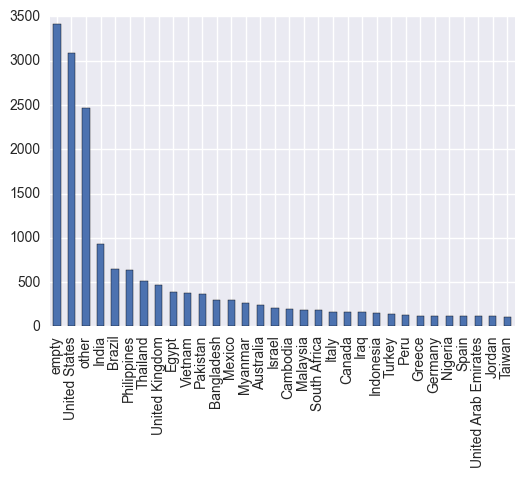

In [51]:
# fill missing countries by city
temp = {k: g["location_country"].tolist() for k,g in all_data.groupby("location_city")}
city_to_country = {}
for city, countries in temp.items():
    if city == 'empty':
        city_to_country[city] = 'empty'
        continue
    for country in countries:
        if country != 'empty':
            city_to_country[city] = country
            break
    if city_to_country.get(city) is None:
        city_to_country[city] = 'empty'
all_data['location_country'] = all_data.apply(lambda x: x['location_country'] if x['location_country'] != 'empty' else city_to_country[x['location_city']], axis=1)

val_count = all_data['location_country'].value_counts()
all_data['country'] = all_data.location_country.apply(lambda x: x if val_count[x] > 100 else 'other')


## Types Conversion

In [52]:
binary_variables = ['has_email', 'has_phone', 'has_website', 'has_location']
text_variables = ['general_info', 'location_city', 'location_country']
categorical_variables = ['country', 'price_range']

for variable in binary_variables:
    all_data[variable] = all_data[variable].astype(int)

## Drop unnecessary columns

In [53]:
all_data.drop(text_variables, axis = 1,  inplace=True)
all_data[:].dtypes

has_cover_photo            int64
has_profile_photo          int64
id                         int64
likes                      int64
fanCount                 float64
is_permanently_closed    float64
is_unclaimed             float64
is_verified              float64
price_range              float64
start_info               float64
talking_about_count      float64
were_here_count          float64
has_email                  int32
has_phone                  int32
has_website                int32
has_location               int32
description_len          float64
general_info_len         float64
name_len                   int64
products_len             float64
name_num_of_words          int64
founded                  float64
country                   object
dtype: object

# Data Exploration

### Numeric features

count    1.693000e+04
mean     4.185899e+05
std      2.452920e+06
min      0.000000e+00
25%      3.848250e+03
50%      2.553350e+04
75%      1.443562e+05
max      1.027625e+08
Name: likes, dtype: float64


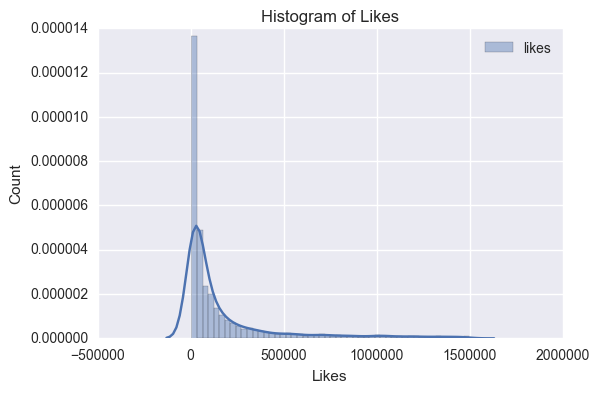

In [15]:
print all_data.likes.describe()
sns.distplot(all_data[(all_data['likes'] > 5000) & (all_data['likes'] < 1500000)].likes, 
             bins = 50, kde = True, label = "likes")
plt.title('Histogram of Likes')
plt.xlabel('Likes')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()


count    1.693000e+04
mean     1.727233e+05
std      1.643106e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.027625e+08
Name: fanCount, dtype: float64


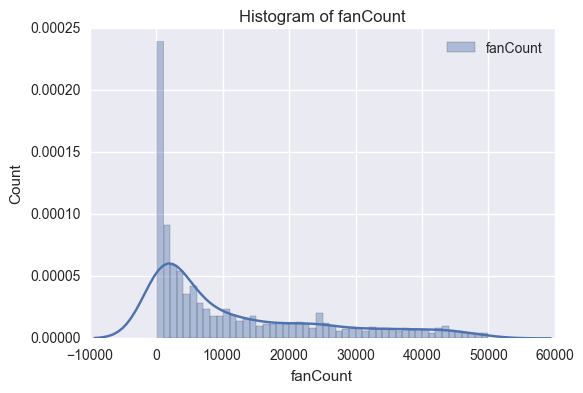

In [16]:
print all_data.fanCount.describe()
sns.distplot(all_data[(all_data['fanCount'] > 100) & (all_data['fanCount'] < 50000)].fanCount, 
             bins = 50, kde = True, label = "fanCount")
plt.title('Histogram of fanCount')
plt.xlabel('fanCount')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

count    1.693000e+04
mean     2.909142e+04
std      2.302768e+05
min      0.000000e+00
25%      1.000000e+01
50%      3.420000e+02
75%      3.572000e+03
max      1.728899e+07
Name: talking_about_count, dtype: float64


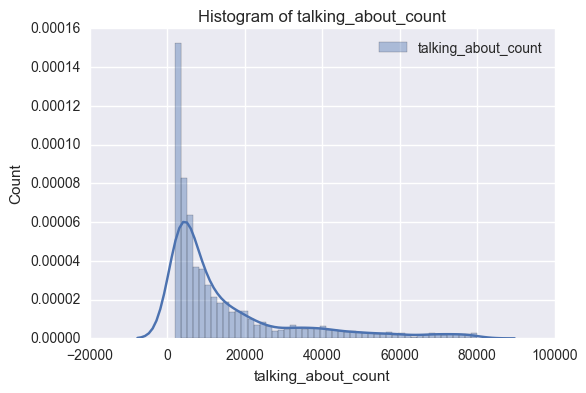

In [17]:
print all_data.talking_about_count.describe()
sns.distplot(all_data[(all_data['talking_about_count'] > 2000) & (all_data['talking_about_count'] < 80000)].talking_about_count, 
             bins = 50, kde = True, label = "talking_about_count")
plt.title('Histogram of talking_about_count')
plt.xlabel('talking_about_count')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

count    1.693000e+04
mean     2.961704e+04
std      3.550105e+05
min      0.000000e+00
25%      0.000000e+00
50%      2.900000e+01
75%      1.644250e+03
max      2.451293e+07
Name: were_here_count, dtype: float64


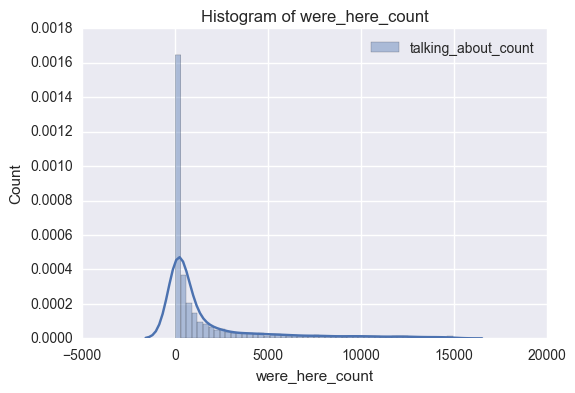

In [18]:
print all_data.were_here_count.describe()
sns.distplot(all_data[(all_data['were_here_count'] > 10) & (all_data['were_here_count'] < 15000)].were_here_count, 
             bins = 50, kde = True, label = "talking_about_count")
plt.title('Histogram of were_here_count')
plt.xlabel('were_here_count')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()


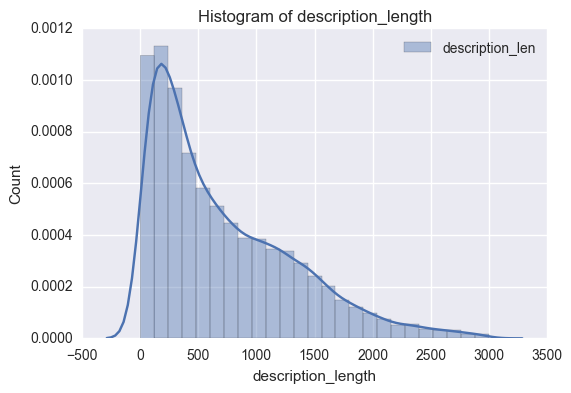

In [19]:
sns.distplot(all_data[(all_data['description_len'] > 0) & (all_data['description_len'] < 3000)].description_len, 
             bins = 25, kde = True, label = "description_len")
plt.title('Histogram of description_length')
plt.xlabel('description_length')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

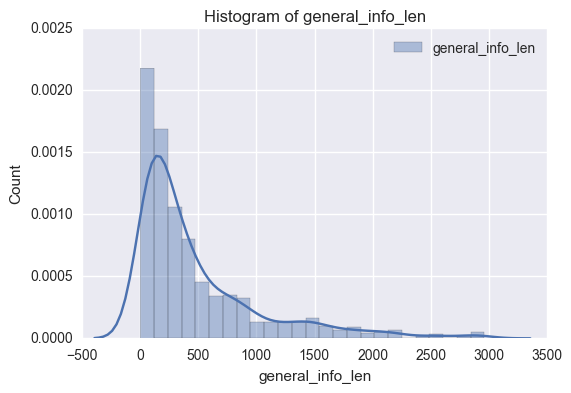

In [20]:
sns.distplot(all_data[(all_data['general_info_len'] > 0) & (all_data['general_info_len'] < 3000)].general_info_len, 
             bins = 25, kde = True, label = "general_info_len")
plt.title('Histogram of general_info_len')
plt.xlabel('general_info_len')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

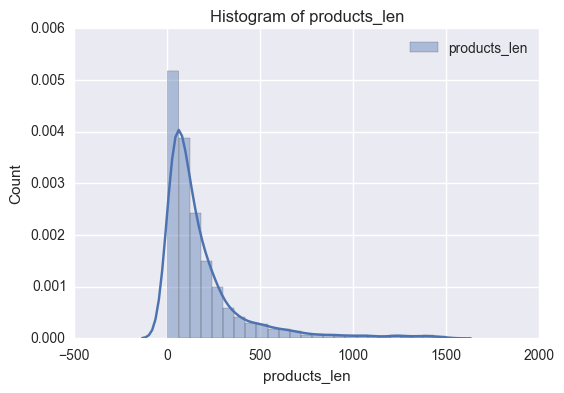

In [21]:
sns.distplot(all_data[(all_data['products_len'] > 0) & (all_data['products_len'] < 1500)].products_len, 
             bins = 25, kde = True, label = "products_len")
plt.title('Histogram of products_len')
plt.xlabel('products_len')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

### Categorical feature bars

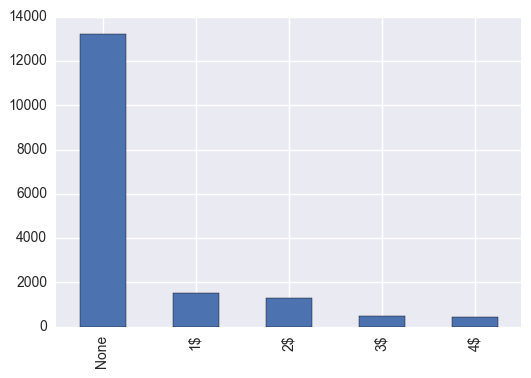

In [25]:
named_labels = all_data.price_range.map({0:'None', 1:'1$', 2:'2$', 3:'3$', 4:'4$'})
named_labels.value_counts().plot(kind='bar')

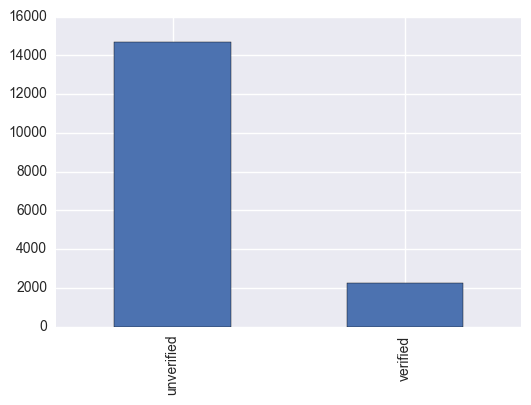

In [26]:
named_labels = all_data.is_verified.map({0:'unverified', 1:'verified'})
named_labels.value_counts().plot(kind='bar')

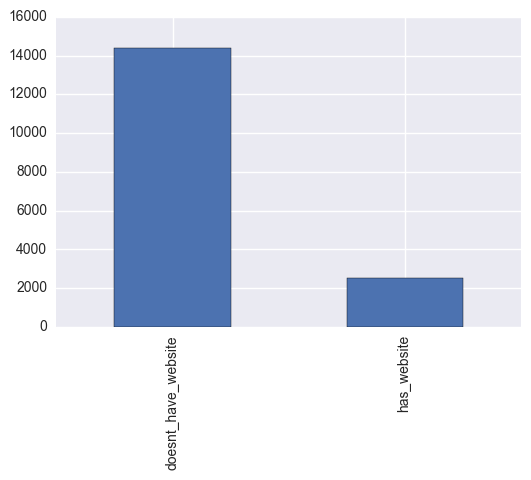

In [27]:
named_labels = all_data.has_website.map({0:'has_website', 1:'doesnt_have_website'})
named_labels.value_counts().plot(kind='bar')

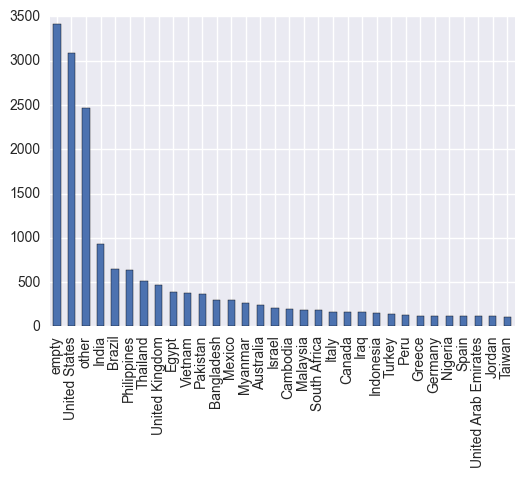

In [57]:
all_data['country'].value_counts().plot(kind='bar')

In [28]:
 all_data[all_data['is_permanently_closed'] == 1].shape[0]

16

In [29]:
 all_data[all_data['likes'] > 1500000].shape[0]

976

In [30]:
detail_variables = ['description_len', 'general_info_len', 'products_len']
all_data[detail_variables].corr()

,description_len,general_info_len,products_len
description_len,1.000000,0.044061,0.096494
general_info_len,0.044061,1.000000,0.019604
products_len,0.096494,0.019604,1.000000


In [31]:
interaction_variables = ['likes', 'fanCount', 'talking_about_count', 'were_here_count']
all_data[interaction_variables].corr()

,likes,fanCount,talking_about_count,were_here_count
likes,1.000000,0.659320,0.246033,0.282423
fanCount,0.659320,1.000000,0.198666,0.021563
talking_about_count,0.246033,0.198666,1.000000,0.012881
were_here_count,0.282423,0.021563,0.012881,1.000000


In [33]:
all_data[['likes'] + detail_variables].corr()

,likes,description_len,general_info_len,products_len
likes,1.000000,-0.000035,0.002344,0.006815
description_len,-0.000035,1.000000,0.044061,0.096494
general_info_len,0.002344,0.044061,1.000000,0.019604
products_len,0.006815,0.096494,0.019604,1.000000


In [ ]:
# TODO: add photo correlations

# photo_variables = ['total_photos', 'number_of_albums', 'number_of_normal_albums', 'number_of_wall_albums', 'number_of_mobile_albums',
#                    'number_of_cover_albums', 'number_of_profile_albums', 'number_of_app_albums', 'number_of_photos_in_normal_albums',
#                    'number_of_photos_in_wall_albums', 'number_of_photos_in_mobile_albums', 'number_of_photos_in_cover_albums', 'number_of_photos_in_profile_albums',
#                    'number_of_photos_in_app_albums', 'number_of_photos_with_tagged_people_without_self', 'number_of_different_photo_uploaders', 'number_of_photos_with_tagged_people_without_self', 'total_number_of_people_tagged_in_photos',
#                    'number_of_photos_self_tagged', 'avg_number_of_people_tagged_in_photos', 'number_of_different_months_for_photos']
# pp_data[photo_variables].corr()

c:\python27\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


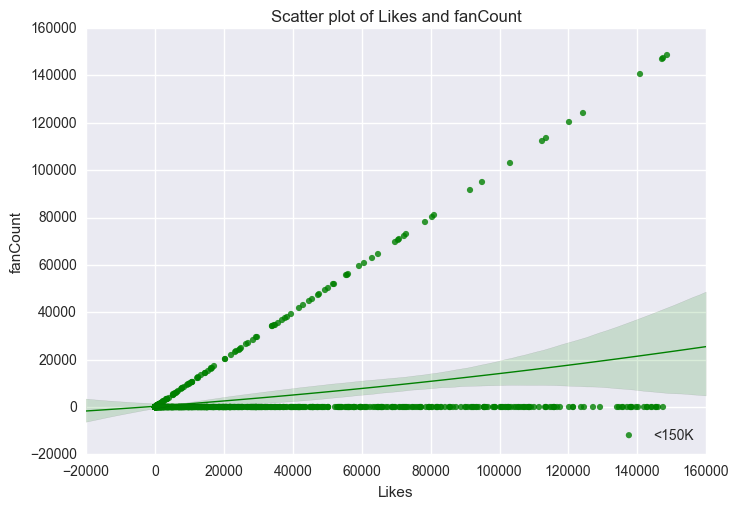

In [34]:
sns.set(color_codes=True)
scatter = pd.DataFrame()
sample = all_data[all_data['likes'] < 150000]
scatter['likes'] = sample['likes']#.apply(lambda x: x/1000)
scatter['fanCount'] = sample['fanCount']#.apply(lambda x: x/1000)
rows = random.sample(scatter.index, 1000)
scatter_10 = scatter.ix[rows]
sns.regplot('likes', 'fanCount', scatter_10, 
            scatter_kws={"marker": ".", "color": "green"},
            line_kws = {"linewidth": "1", "color": "green"},
            order = 2,
            label = '<150K')
plt.xlabel('Likes')
plt.ylabel('fanCount')
plt.legend(loc="lower right")
plt.title("Scatter plot of Likes and fanCount")

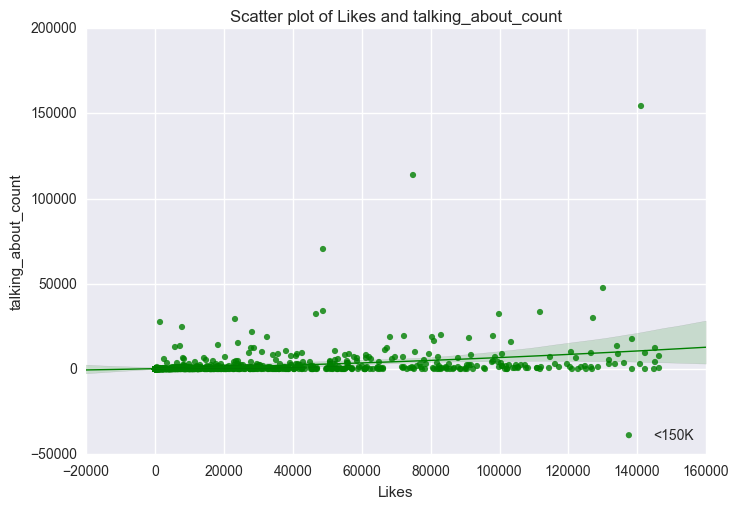

In [35]:
sns.set(color_codes=True)
scatter = pd.DataFrame()
sample = all_data[all_data['likes'] < 150000]
scatter['likes'] = sample['likes']#.apply(lambda x: x/1000)
scatter['talking_about_count'] = sample['talking_about_count']#.apply(lambda x: x/1000)
rows = random.sample(scatter.index, 1000)
scatter_10 = scatter.ix[rows]
sns.regplot('likes', 'talking_about_count', scatter_10, 
            scatter_kws={"marker": ".", "color": "green"},
            line_kws = {"linewidth": "1", "color": "green"},
            order = 2,
            label = '<150K')
plt.xlabel('Likes')
plt.ylabel('talking_about_count')
plt.legend(loc="lower right")
plt.title("Scatter plot of Likes and talking_about_count")

In [54]:
categorical_variables = ['country']

for variable in categorical_variables:
  print ("-------------------------------")
  print ("Histogram for " + variable)
  print ("-------------------------------")
  print (all_data[variable].value_counts())
  print ("")

-------------------------------
Histogram for country
-------------------------------
empty                   3416
United States           3090
other                   2465
India                    932
Brazil                   646
Philippines              639
Thailand                 507
United Kingdom           472
Egypt                    393
Vietnam                  377
Pakistan                 369
Bangladesh               302
Mexico                   293
Myanmar                  262
Australia                244
Israel                   213
Cambodia                 202
Malaysia                 189
South Africa             183
Italy                    168
Canada                   167
Iraq                     160
Indonesia                152
Turkey                   142
Peru                     130
Greece                   123
Germany                  122
Nigeria                  121
Spain                    115
United Arab Emirates     114
Jordan                   112
Taiwan         

#  Data cleaning

## Remove Outliers

In [58]:
filtered_all_data = all_data.copy()
filtered_all_data = filtered_all_data[filtered_all_data['is_permanently_closed'] != 1]
filtered_all_data.drop('is_permanently_closed', axis = 1,  inplace=True)

# Models

## Preprocessing

### dummies variables 

In [60]:
# change back empty and 0 to NaN before converting to dummy variables
country_dv = pd.get_dummies(all_data['country'].apply(lambda x: x if x != 'empty' else np.nan), prefix='country')
price_dv = pd.get_dummies(all_data['price_range'].apply(lambda x: x if x > 0 else np.nan), prefix='price_range')

pp_data = pd.concat([all_data, country_dv, price_dv], axis=1)
pp_data.drop(categorical_variables, 1, inplace=True)
pp_data[:].dtypes

has_cover_photo                   int64
has_profile_photo                 int64
id                                int64
likes                             int64
fanCount                        float64
is_permanently_closed           float64
is_unclaimed                    float64
is_verified                     float64
price_range                     float64
start_info                      float64
talking_about_count             float64
were_here_count                 float64
has_email                         int32
has_phone                         int32
has_website                       int32
has_location                      int32
description_len                 float64
general_info_len                float64
name_len                          int64
products_len                    float64
name_num_of_words                 int64
founded                         float64
country_Australia                 uint8
country_Bangladesh                uint8
country_Brazil                    uint8


In [61]:
pp_data.head(5)

,has_cover_photo,has_profile_photo,id,likes,fanCount,is_permanently_closed,is_unclaimed,is_verified,price_range,start_info,...,country_Turkey,country_United Arab Emirates,country_United Kingdom,country_United States,country_Vietnam,country_other,price_range_1.0,price_range_2.0,price_range_3.0,price_range_4.0
0,1,1,109626372391961,13311,13311.0,0.0,0.0,0.0,2.0,2009.0,...,0,0,0,0,0,0,0,1,0,0
1,1,1,834585939923334,16361,16361.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,10150149049510092,6947,6947.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
3,1,1,57843015021,227010,227010.0,0.0,0.0,1.0,0.0,2007.0,...,0,0,1,0,0,0,0,0,0,0
4,1,1,226269077569044,288531,288531.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


### split to test and train

In [62]:
train_set, test_set = train_test_split(pp_data, test_size = 0.2)
print len(train_set), len(test_set)

13544 3386


## Utils

In [90]:
def binning(col,bin_num, labels=None):
    if labels is None:
        labels = ['BIN_'+str(i) for i in range(bin_num)]

    colBin = pd.qcut(col,bin_num,labels=labels)
# TODO - rename bins by min-max vals
#     df = DataFrame()
#     df['col'] = col
#     df['bins'] = colBin
#     grouped = df['col'].groupby('bins')
    
    return colBin

def plot_results(x, y, tag, arg):
    plt.plot(x, y)
    plt.title(tag + " as a function of " + arg)
    plt.xlabel(arg)
    plt.ylabel(tag)
    plt.show()

def plot_cross_val(cs, cv_scores, arg):
    plt.plot(cs, cv_scores)
    plt.title("Average Precision as a function of " + arg)
    plt.xlabel(arg)
    plt.ylabel("Precision")
    ax = plt.axes()
    ax.set_xscale('log')
    plt.show()

def plotRoc(fpr, tpr, auc):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def plotPR(precision, recall):
    plt.figure()
    plt.plot(recall, precision, label='PR curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall curve')
    plt.legend(loc='lower left')
    plt.show()

def plotMetrics(expected,predicted):
    y_true = expected
    y_score = predicted
    #y_score = df['rawPrediction'].map(lambda x: x['values'][1])
    auc = sklearn.metrics.roc_auc_score(y_true, y_score)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
    plotRoc(fpr, tpr, auc)
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score, pos_label=1)
    plotPR(precision, recall)

def plotConfusion(matrix, n):
    plt.title('Confusion Matrix Image')
    plt.imshow(np.reshape(matrix, (n, n)), interpolation='nearest', cmap="hot")
    plt.colorbar()
    plt.show()

### Convert likes count to bins and print bin details

In [91]:
train_len = int(len(pp_data['id']) * 0.8)
bin_num = 4
pp_data['labels'] = binning(pp_data['likes'], bin_num)

print pp_data.groupby('labels')['likes'].describe()

labels       
BIN_0   count    4.233000e+03
        mean     1.166528e+03
        std      1.128425e+03
        min      0.000000e+00
        25%      1.720000e+02
        50%      7.920000e+02
        75%      1.954000e+03
        max      3.848000e+03
BIN_1   count    4.232000e+03
        mean     1.232180e+04
        std      6.197201e+03
        min      3.849000e+03
        25%      6.931750e+03
        50%      1.108900e+04
        75%      1.709425e+04
        max      2.553100e+04
BIN_2   count    4.232000e+03
        mean     6.604996e+04
        std      3.276835e+04
        min      2.553600e+04
        25%      3.826975e+04
        50%      5.661250e+04
        75%      9.019450e+04
        max      1.442520e+05
BIN_3   count    4.233000e+03
        mean     1.594642e+06
        std      4.713865e+06
        min      1.443910e+05
        25%      2.502490e+05
        50%      5.366170e+05
        75%      1.393747e+06
        max      1.027625e+08
Name: likes, dtype: float6

## Random Forest

### Preprocessing

In [92]:
rf_train_len = train_len
rf_labels = pp_data['labels']
rf_ids = pp_data['id']

rf_train_set = pp_data[:rf_train_len].copy()
rf_test_set = pp_data[rf_train_len:].copy()


rf_train_ids = rf_ids[:rf_train_len].copy()
rf_test_ids = rf_ids[rf_train_len:].copy()

rf_train_labels = rf_labels[:rf_train_len].copy()
rf_test_labels = rf_labels[rf_train_len:].copy()

rf_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
rf_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)



### Parameter optimization

Feature ranking - Top 10:
1. feature 8 (talking_about_count)
   score: 0.284260
2. feature 2 (fanCount)
   score: 0.179665
3. feature 9 (were_here_count)
   score: 0.058798
4. feature 5 (is_verified)
   score: 0.055575
5. feature 16 (name_len)
   score: 0.053057
6. feature 4 (is_unclaimed)
   score: 0.051090
7. feature 14 (description_len)
   score: 0.040435
8. feature 7 (start_info)
   score: 0.034444
9. feature 18 (name_num_of_words)
   score: 0.027720
10. feature 17 (products_len)
   score: 0.025257


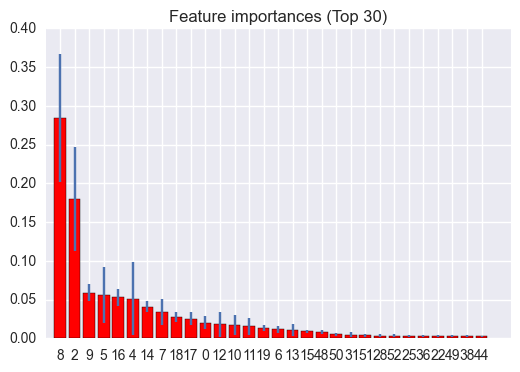

In [71]:
forest = RandomForestClassifier(n_estimators=250, max_depth=15)
forest.fit(rf_train_set.values, rf_train_labels.values)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking - Top 10:")
for f in range(10):
    print("%d. feature %d (%s)\n   score: %f" % (f + 1, indices[f], list(rf_train_set)[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plot_idxs = indices[:30]
plt.figure()
plt.title("Feature importances (Top 10)")
plt.bar(range(30), importances[plot_idxs],
       color="r", yerr=std[plot_idxs], align="center")
plt.xticks(range(30), plot_idxs)
plt.xlim([-1, 31])
plt.show()

In [74]:
importances_thresholds = [0, 0.01, 0.02, 0.03, 0.04]
max_depths = [10, 20, 30, None]
min_samples_leaf = [1, 3, 5]

filtered_by_thresholds = []
for t in importances_thresholds:
    columns = []
    for f in range(rf_train_set.shape[1]):
        if importances[indices[f]] >= t:
            columns.append(list(rf_train_set)[indices[f]])
    filtered_by_thresholds.append(columns)

params = []
score_summary = []
print "(threshold, depth, min_samples) -> average precision score"
for i in range(len(filtered_by_thresholds)):
    for d in max_depths:
        for l in min_samples_leaf:
            cols = filtered_by_thresholds[i]
            forest = RandomForestClassifier(n_estimators=250, random_state=0, max_depth=d, min_samples_leaf=l)
            forest.fit(rf_train_set, rf_train_labels)
            temp_predictions = forest.predict(rf_test_set)
            res = metrics.precision_score(rf_test_labels, temp_predictions, average='macro')
            score_summary.append(res)
            params.append((importances_thresholds[i], d, l))
            print "%s -> %s" % (params[-1], score_summary[-1])
    
max_idx = np.argmax(score_summary)
best_threshold = params[max_idx][0]
best_max_depth = params[max_idx][1]
best_min_leaf = params[max_idx][2]

# Print best hyper parameters
print "RF best parameters:"
print "max_depth = ", best_max_depth
print "importance_threshold = ", best_threshold
print "min_samples_leaf = ", best_min_leaf

(threshold, depth, min_samples) -> average precision score
(0, 10, 1) -> 0.60895673735
(0, 10, 3) -> 0.605271327144
(0, 10, 5) -> 0.603165281436
(0, 20, 1) -> 0.622693714823
(0, 20, 3) -> 0.614824798696
(0, 20, 5) -> 0.617309487563
(0, 30, 1) -> 0.618891047834
(0, 30, 3) -> 0.617115215568
(0, 30, 5) -> 0.614645178827
(0, None, 1) -> 0.614255062286
(0, None, 3) -> 0.619343753464
(0, None, 5) -> 0.614397384734
(0.01, 10, 1) -> 0.60895673735
(0.01, 10, 3) -> 0.605271327144
(0.01, 10, 5) -> 0.603165281436
(0.01, 20, 1) -> 0.622693714823
(0.01, 20, 3) -> 0.614824798696
(0.01, 20, 5) -> 0.617309487563
(0.01, 30, 1) -> 0.618891047834
(0.01, 30, 3) -> 0.617115215568
(0.01, 30, 5) -> 0.614645178827
(0.01, None, 1) -> 0.614255062286
(0.01, None, 3) -> 0.619343753464
(0.01, None, 5) -> 0.614397384734
(0.02, 10, 1) -> 0.60895673735
(0.02, 10, 3) -> 0.605271327144
(0.02, 10, 5) -> 0.603165281436
(0.02, 20, 1) -> 0.622693714823
(0.02, 20, 3) -> 0.614824798696
(0.02, 20, 5) -> 0.617309487563
(0.02, 3

### RF running

Random Forest test precision: 0.617422588401


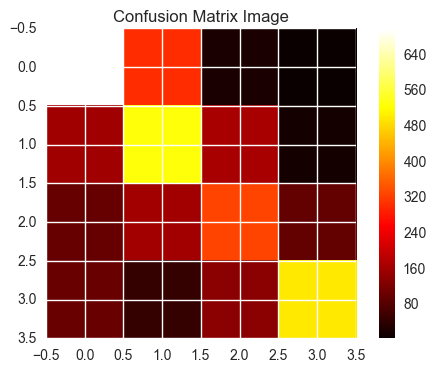

In [75]:
fc = filtered_by_thresholds[importances_thresholds.index(best_threshold)]
forest = RandomForestClassifier(n_estimators=250, random_state=0, max_depth=best_max_depth, min_samples_leaf=best_min_leaf, oob_score=True)
forest.fit(rf_train_set[fc].values, rf_train_labels)
rf_train_predicted_probs = forest.predict_proba(rf_train_set[fc])
rf_test_predicted_probs = forest.predict_proba(rf_test_set[fc])
rf_test_predictions = forest.predict(rf_test_set[fc])
res = metrics.precision_score(rf_test_labels, rf_test_predictions, average='macro')
print "Random Forest test precision:", res

cm_rf_labels = rf_test_labels.apply(lambda x: x[-1])
cm_rf_predictions = [a[-1] for a in rf_test_predictions.tolist()]
m = confusion_matrix(cm_rf_labels.values, cm_rf_predictions)
plotConfusion(m, bin_num)

## Logistic Regression

### Preprocessing

In [49]:
lr_train_len = 13544
# lr_labelsfrom sklearn.metrics import confusion_matrixfrom sklearn.metrics import confusion_matrix = pp_data['likes']
lr_labels = pp_data['likes'].apply(lambda x: 0 if x < 25000 else 1)
lr_ids = pp_data['id']

lr_train_set = pp_data[:lr_train_len].copy()
lr_test_set = pp_data[lr_train_len:].copy()

lr_train_labels = lr_labels[:lr_train_len].copy()
lr_test_labels = lr_labels[lr_train_len:].copy()

lr_train_ids = lr_ids[:lr_train_len].copy()
lr_test_ids = lr_ids[lr_train_len:].copy()

lr_train_set.drop(['likes', 'id'], 1, inplace=True)
lr_test_set.drop(['likes', 'id'], 1, inplace=True)
lr_set = lr_train_set.append(lr_test_set, ignore_index=True)

### Parameter optimization

C=1e-12: 0.899169977965
C=1e-11: 0.91093623707
C=1e-10: 0.912262425699
C=1e-09: 0.914324972434
C=1e-08: 0.911293573535
C=1e-07: 0.910814442175
C=1e-06: 0.910764476463
C=1e-05: 0.910758450928


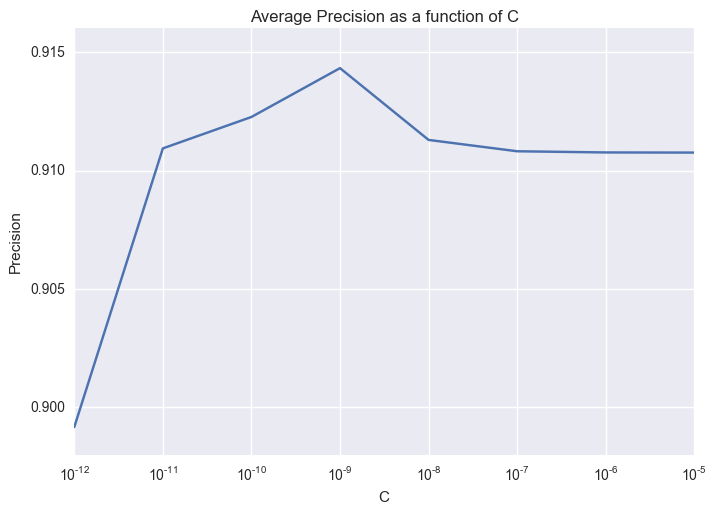

In [54]:
cv_scores = []
space = np.logspace(-12,-5, num=8)
for c in space:
    res = cross_val_score(lm.LogisticRegression(penalty='l2', C=c), lr_train_set, lr_train_labels, cv=10, scoring='average_precision')
    print "C=%s: %s" % (c, np.average(res))
    cv_scores.append(np.average(res))

plot_cross_val(space, cv_scores, "C")
lr_selceted_c = space[cv_scores.index(max(cv_scores))]

C=1e-10: 0.912262425699
C=2.15443469003e-10: 0.913198564309
C=4.64158883361e-10: 0.914043193975
C=1e-09: 0.914324972434
C=2.15443469003e-09: 0.912892238021
C=4.64158883361e-09: 0.911911417466
C=1e-08: 0.911293573535


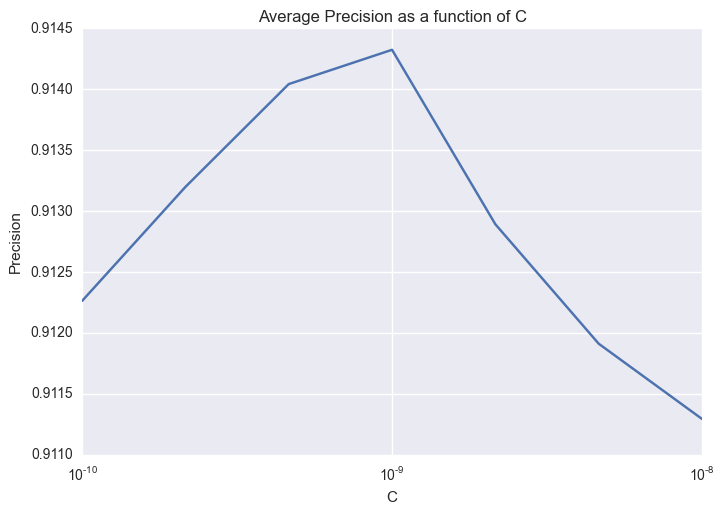

In [55]:
cv_scores = []
space = np.logspace(-10,-8, num=7)
for c in space:
    res = cross_val_score(lm.LogisticRegression(penalty='l2', C=c), lr_train_set, lr_train_labels, cv=10, scoring='average_precision')
    print "C=%s: %s" % (c, np.average(res))
    cv_scores.append(np.average(res))

plot_cross_val(space, cv_scores, "C")
lr_selceted_c = space[cv_scores.index(max(cv_scores))]

### LR running 

training logistic regression
getting logistic regression predictions
calculating logistic regression Performance on the train set:

c:\python27\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



logistic regression train set auc: 0.888311620072


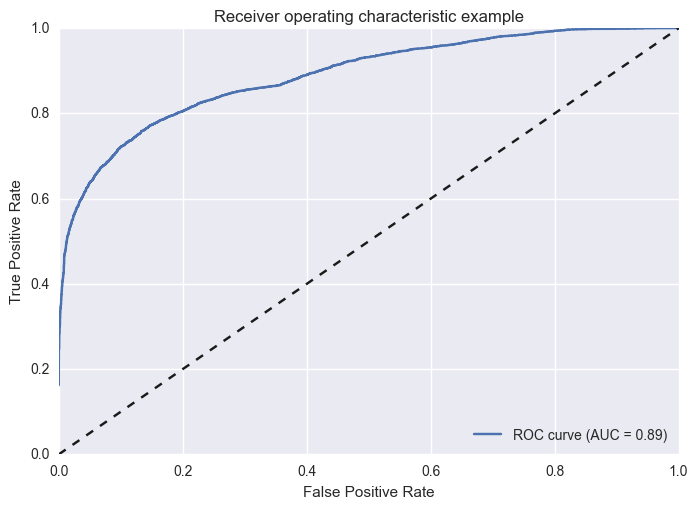

calculating logistic regression Performance on the test set:
             precision    recall  f1-score   support

          0       0.70      0.97      0.81      1894
          1       0.93      0.48      0.63      1492

avg / total       0.80      0.75      0.73      3386



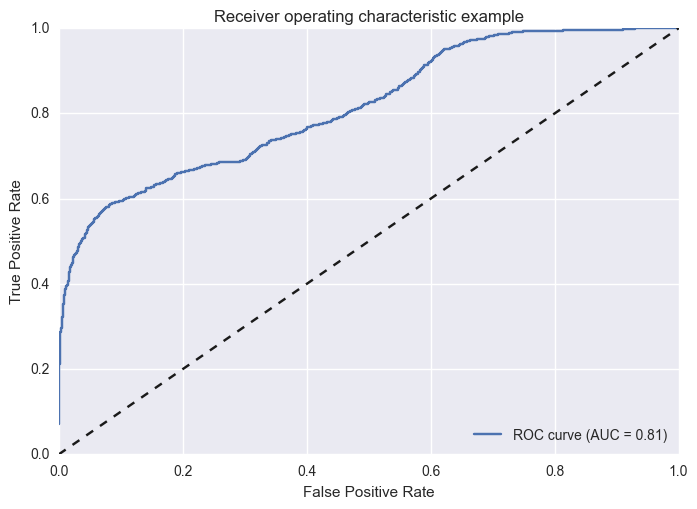

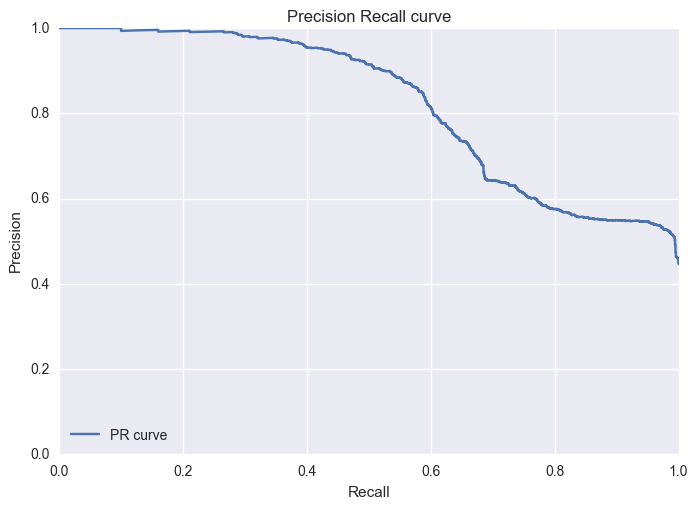

In [56]:
print "training logistic regression"
lr = lm.LogisticRegression(penalty='l2', C=lr_selceted_c)  #penalty='l2' #dual=True) #lr_selceted_c)

lr.fit(lr_train_set, lr_train_labels)
print "getting logistic regression predictions"
lr_predicted_probs = lr.predict_proba(lr_set)[:, 1]
lr_predictions = lr.predict(lr_set)

lr_train_predicted_probs = lr_predicted_probs[:lr_train_len]
lr_test_predicted_probs = lr_predicted_probs[lr_train_len:]

lr_train_predictions = lr_predictions[:lr_train_len]
lr_test_predictions = lr_predictions[lr_train_len:]


for_csv = pd.DataFrame()
for_csv['id'] = lr_test_ids
for_csv['label'] = lr_test_predicted_probs
for_csv.to_csv("lr_test_predictions.csv", index=False)

print "calculating logistic regression Performance on the train set:"
fpr, tpr, thresholds = metrics.roc_curve(lr_train_labels, lr_train_predicted_probs)
lr_auc = metrics.auc(fpr, tpr)
print "logistic regression train set auc:", lr_auc
plotRoc(fpr, tpr, lr_auc)
print "calculating logistic regression Performance on the test set:"
print(metrics.classification_report(lr_test_labels, lr_test_predictions))
plotMetrics(lr_test_labels,lr_test_predicted_probs)

# pected = test_class.values
# oh_test_data= oh_test.drop('class',axis=1)
# predicted = logreg.predict(oh_test_data)
# predicted_probs = logreg.predict_proba(oh_test_data)

#add LR score as a new feature
# train_set['logistic_regression_prediction'] = lr_train_predictions
# test_set['logistic_regression_prediction'] = lr_test_predictions

## SVM

### Preprocessing

In [57]:
svm_train_len = 2000 #13544
svm_test_len = 200

svm_pp_data = all_data.copy()
svm_pp_data.drop(categorical_variables, 1, inplace=True)

svm_labels = svm_pp_data['likes'].apply(lambda x: 0 if x < 25000 else 1)
svm_ids = svm_pp_data['id']

svm_train_set = svm_pp_data[:svm_train_len].copy()
svm_test_set = svm_pp_data[svm_train_len:svm_train_len+svm_test_len].copy()

svm_train_labels = svm_labels[:svm_train_len].copy()
svm_test_labels = svm_labels[svm_train_len:svm_train_len+svm_test_len].copy()

svm_train_ids = svm_ids[:svm_train_len].copy()
svm_test_ids = svm_ids[svm_train_len:svm_train_len+svm_test_len].copy()

svm_train_set.drop(['likes', 'id'], 1, inplace=True)
svm_test_set.drop(['likes', 'id'], 1, inplace=True)
svm_set = svm_train_set.append(svm_test_set, ignore_index=True)

### Parameter optimization 

C=1e-05: 0.732600385235
C=0.0001: 0.732899979223
C=0.001: 0.757901051888
C=0.01: 0.757901051888
C=0.1: 0.758045322646
C=1: 0.759129276036
C=10: 0.758757252227
C=100: 0.758757252227


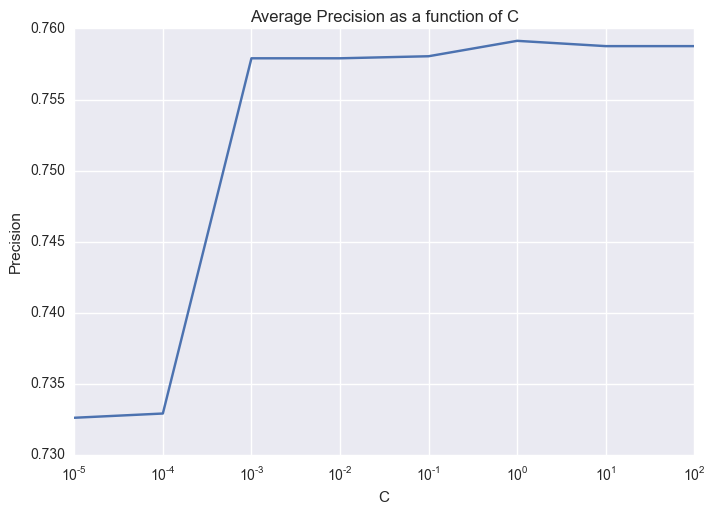

In [60]:
cv_scores = []
cs = []
for c in range(-5,3):#-2,2):
    res = cross_val_score(svm.SVC(C=10**c), svm_train_set, svm_train_labels, cv=10, scoring='average_precision')
    print "C=%s: %s" % (10**c, np.average(res))
    cs.append(10**c)
    cv_scores.append(np.average(res))
    
plot_cross_val(cs, cv_scores, "C")
svm_selceted_c = cv_scores[cv_scores.index(max(cv_scores))]

### SVM run

In [518]:
# svm_selceted_c = 16.681005372
# svm_selceted_gamma = 0.0316227766017

svm_model = svm.SVC(probability=True, C=svm_selceted_c, gamma=svm_selceted_gamma)
svm_model.fit(pp_train_set, pp_train_labels)
svm_train_prediction = svm_model.predict_proba(pp_train_set)
svm_test_prediction = svm_model.predict_proba(pp_test_set)

fpr, tpr, thresholds = metrics.roc_curve(pp_train_labels, svm_train_prediction[:,1])
svm_train_auc = metrics.auc(fpr, tpr)
print "svm train set auc:", svm_train_auc

plotRoc(fpr, tpr, svm_train_auc)

for_csv = pd.DataFrame()
for_csv['urlid'] = pp_test_urlids
for_csv['label'] = svm_test_prediction[:,1]
for_csv.to_csv("svm_test_predictions.csv", index=False)

(6689, 191)

## LR - numrical predictions - DELETE ME

In [61]:
lr2_pp_data = all_data.copy()
lr2_pp_data.drop(categorical_variables, 1, inplace=True)
lr2_pp_data = lr2_pp_data[lr2_pp_data['likes'] > 50000]
lr2_pp_data = lr2_pp_data.sample(frac=1)

lr2_train_len = 1000
lr2_test_len = 100
lr2_labels = pp_data['likes']
lr2_ids = pp_data['id']

lr2_train_set = pp_data[:lr2_train_len].copy()
lr2_test_set = pp_data[lr2_train_len:lr2_train_len+lr2_test_len].copy()

lr2_train_labels = lr2_labels[:lr2_train_len].copy()
lr2_test_labels = lr2_labels[lr2_train_len:lr2_train_len+lr2_test_len].copy()

lr2_train_ids = lr2_ids[:lr2_train_len].copy()
lr2_test_ids = lr2_ids[lr2_train_len:lr2_train_len+lr2_test_len].copy()

lr2_train_set.drop(['likes', 'id'], 1, inplace=True)
lr2_test_set.drop(['likes', 'id'], 1, inplace=True)
lr2_set = lr2_train_set.append(lr2_test_set, ignore_index=True)

In [62]:
lr2 = lm.LogisticRegression(penalty='l1', C=10**(-3))  #penalty='l2' #dual=True) #lr_selceted_c)

print "training logistic regression"
lr2.fit(lr2_train_set, lr2_train_labels)

print "getting logistic regression predictions"
lr2_predictions = lr2.predict(lr2_set)

print "calculating logistic regression Performance on the test set:"
lr2.score(lr2_test_set, lr2_test_labels, sample_weight=None)

# lr2_train_predicted_probs = lr2_predicted_probs[:lr_train_len]
# lr2_test_predicted_probs = lr2_predicted_probs[lr_train_len:]

# lr2_train_predictions = lr2_predictions[:lr_train_len]
# lr2_test_predictions = lr2_predictions[lr_train_len:]

training logistic regression
getting logistic regression predictions
calculating logistic regression Performance on the test set:


0.0

In [63]:
predicted = lr2_predictions[lr2_train_len:]
actual = lr2_test_labels.values
ratio = np.divide(predicted * 1.0, actual)

print 'median: ', np.median(ratio)
print 'mean: ', ratio.mean()
print 'std: ', ratio.std()
print 'min: ', ratio.min()
print 'max: ', ratio.max()


median:  1.3370815948
mean:  1.61211175502
std:  1.40803569521
min:  0.0
max:  7.02683595441


<function matplotlib.pyplot.show>

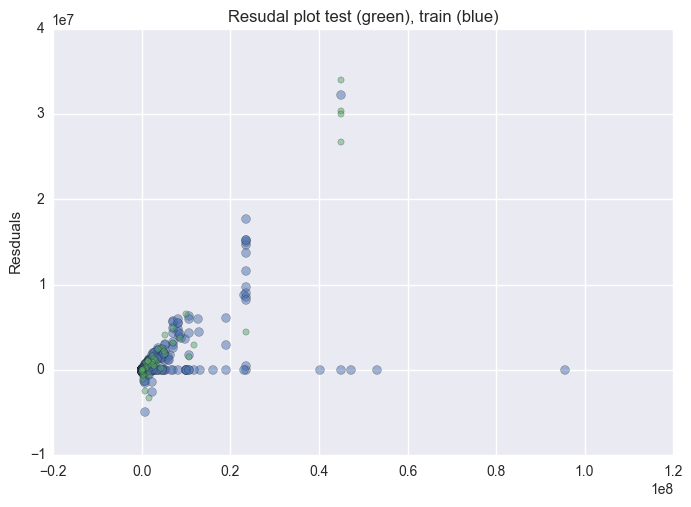

In [65]:
#TODO: add scatter plot predicted vs actual

plt.scatter(lr2_predictions[:lr2_train_len], lr2_predictions[:lr2_train_len] -  lr2_train_labels, c='b', s=40, alpha=0.5)
plt.scatter(lr2_predictions[lr2_train_len:], lr2_predictions[lr2_train_len:] -  lr2_test_labels, c='g', alpha=0.5)
plt.hlines(y=0, xmin=-10, xmax=50)
plt.title('Resudal plot test (green), train (blue)')
plt.ylabel('Resduals')
plt.show